# Calculate total horizontal flux from sediment weights
 - Here, we take the measured mass output from the BSNE samplers, weight by inlet area, and divide by number of days between each sample. This gives a measure for flux: Mass/(Area*Time)
 - Sediment data comes from the Big Spring Number Eight (BSNE) aeolian sediment traps
 - Each BSNE trap collects data at 4 different heights. There are 9 traps total at NEAT1, so a total of 4*9 = 36 measurements for each time stamp. We want the mean horizontal flux for each day, computed using these 36 measurements

In [1]:
""" compute_Q_NEAT_sites.ipynb 
Used as a preprocessing and data wrangling step for the WEMO model calibration

Author: Nicole Keeney 
Date Created: 06/09/2021 
Modification History: 
    - slight modifcations, updated filepaths, retrieved code that was accidentally deleted (10/8/2021)
    
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from functools import reduce

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 75

## Compute days between each sample

In [2]:
neat_num = '1'# NEAT site to use: 1,2, or 3

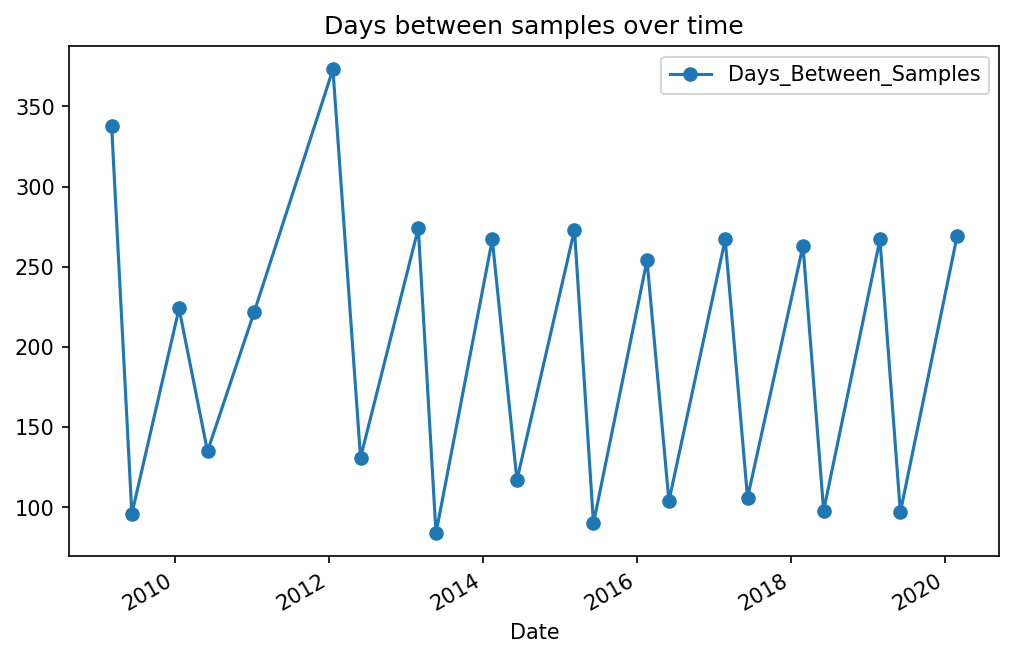

In [3]:
# Read data
q_path = "../data/site_data/NEAT"+neat_num+"/sediment_weights/NEAT_Block"+neat_num+"_Control_FINAL.csv"
df_q_orig = pd.read_csv(q_path) # Read in file
df_q = df_q_orig.iloc[:,3:-5]

# Get dates and reindex 
dates = pd.to_datetime(df_q.columns.values) # Get dates from column names
df_q = df_q.T # Transpose & reindex using datetime dates 
df_q.index.name = "Date"

# Loop through DataFrame to determine number of days between each sample 
dates_df = pd.DataFrame({"First Date": dates[:-1], "Date": dates[1:]})
dates_df["Days_Between_Samples"] = (dates_df["Date"] - dates_df["First Date"]).astype('timedelta64[D]') # Compute days between 
dates_df = dates_df.set_index("Date") # Set date as index 
df_q = df_q.iloc[1:] # Remove first date

# Display result
dates_df.reset_index().plot(kind = 'line', x = 'Date', y = 'Days_Between_Samples', title = "Days between samples over time", figsize = (8,5), marker = 'o');

# Compute total flux for each sampler
Use days between measurement (time) and inlet area to compute a flux (mass/(time*area))

In [4]:
# Compute horizontal flux using inlet area and days between samples
inlet_area = 0.00105 # Area of inlet =  1050 mm^2, convert to m^2
Q_act_sampler = [] # Actual horizontal flux at each timestamp 
for i in range(len(df_q.columns)): 
    Q_ = df_q[i].values/(dates_df['Days_Between_Samples'].values*inlet_area)
    Q_ = pd.DataFrame({i:Q_})
    Q_act_sampler.append(Q_)

Q_act_sampler = pd.concat(Q_act_sampler, axis=1, join="inner").T # Concatenate all DataFrames
Q_act_sampler.index.name = "Sampler"
Q_act_sampler.columns = df_q.index
Q_act_sampler[Q_act_sampler==0] = np.nan # If any number is 0 then curve.fit function does not work. Set 0 to np.nan

# Add collector and stand ID as columns 
collectors = df_q_orig[["Stand_id","Collector"]]
Q_act_sampler = collectors.merge(Q_act_sampler, left_index=True, right_index=True)


# Display results
print("Horizontal Aeolian flux from BSNE samplers, weighted by time and inlet area")
display(Q_act_sampler.head())

Horizontal Aeolian flux from BSNE samplers, weighted by time and inlet area


,Stand_id,Collector,3/5/09 0:00,6/9/09 0:00,1/19/10 0:00,6/3/10 0:00,1/11/11 0:00,1/19/12 0:00,5/29/12 0:00,2/27/13 0:00,...,6/8/15 0:00,2/17/16 0:00,5/31/16 0:00,2/22/17 0:00,6/8/17 0:00,2/26/18 0:00,6/4/18 0:00,2/26/19 0:00,6/3/19 0:00,2/27/20 0:00
0,D1,A,26.951254,11.825397,20.697279,31.266314,50.360360,26.041108,24.645583,25.891554,...,35.375661,103.063367,75.595238,161.494560,355.876011,3.331523,319.008746,99.486356,1143.986254,71.655160
1,D1,B,5.156382,4.067460,4.413265,13.693122,11.106821,7.174773,13.558706,7.427876,...,11.523810,26.629171,25.741758,50.065989,136.891285,31.146116,33.158406,29.645086,397.221404,20.421314
2,D1,C,1.780783,3.621032,1.237245,6.109347,2.385242,2.206051,9.894584,3.521029,...,4.031746,6.711661,14.615385,17.503121,44.573226,8.962520,17.220603,10.650972,142.130584,12.189768
3,D1,D,1.160890,2.371032,1.130952,3.562610,0.836551,1.011107,8.658670,1.870003,...,2.899471,3.149606,8.864469,11.182451,42.273136,4.544632,14.470360,6.381309,130.643103,3.682068
4,D2,A,25.483235,7.688492,10.119048,NaN,33.856714,24.680199,13.282443,18.467153,...,43.322751,131.038620,138.672161,282.949884,902.767296,95.230853,78.143829,37.767077,1267.206676,80.814303


# Compute time-averaged horizontal fluxover all BSNE samplers
 - The height for each BSNE gives dz to use to compute Q(t, act)
 - Each BSNE sampler measures mass at four different heights (z): 0.15, 0.30, 0.60, 1.20

In [5]:
# Fit an exponential curve to get the fitting coefficients
def exp_func(z, a, b, c):
    q = c * np.exp(-a * z**2 + b * z)
    return q

# You need to compute a, b, and c beforehand, using the function exp_func
# Time-averaged horizontal mass flux density
def int_func(x):
    return c * np.exp(a * x**2 + b * x)

In [6]:
# z is height for each BSNE, q is mass/length.time. This is the height of each collector for each sampler
heights = [0.15,0.30,0.60,1.20]

# Get only upwind or downwind samplers 
upwind_ids = [stand_id for stand_id in Q_act_sampler["Stand_id"].values if "U" in str(stand_id)]
downwind_ids = [stand_id for stand_id in Q_act_sampler["Stand_id"].values if "D" in str(stand_id)]
#Q_act_sampler[Q_act_sampler["Stand_id"].isin(downwind_ids)] = np.nan # Only get upwind/downwind data

# Get Q for each BSNE sampler
dfList = []
for stand_id, group in Q_act_sampler.groupby("Stand_id"): 
    df_measurements = group.T
    df_measurements.columns = df_measurements.loc["Collector"]
    df_measurements = df_measurements.drop(labels=["Stand_id","Collector"],axis=0)
    df_measurements.index.name = "Date"

    # Get measurements by date
    bsne_by_stand_id = []
    
    for date in df_measurements.index: # Get measurements by date
        bsne = df_measurements.loc[date] # Four measurements from each height for each BSNE sampler 
        
        # See if any collectors have null values 
        bsne_null = bsne.isnull() # Get True False for if collector is null 
        collectors_null = bsne_null[bsne_null == True].index # Check which collectors have null 
        
        if "A" in collectors_null: # If lowest collector is nan, set entire stand ID at that date to nan
            Q_obs = np.nan
        
        elif len(collectors_null) >= 2: # If 2 or more of the three higher collectors is nan, set entire stand ID at that date to nan
            Q_obs = np.nan
        
        else: 
            # Remove any nan values in other collectors 
            # You need to do this to use the curve_fit function
            bsne = pd.DataFrame(bsne)
            bsne["heights"] = heights # Add associated heights to each collector
            bsne = bsne.dropna()
            
            # Find values for a,b,c in q(z)
            bsne_vals = bsne[date].values.astype(float)
            heights_iter = bsne["heights"].values
            popt, pcov = curve_fit(exp_func, bsne["heights"].values, bsne_vals, maxfev = 5000)
            a,b,c = popt[0],popt[1],popt[2]

            # Integrate q(z) from 0-1m to get Q(t, act)
            Q_obs = integrate.quad(int_func, 0, 1)[0]
            
            
        bsne_by_stand_id.append(Q_obs)

    df_stand_id = pd.DataFrame({"Q (" + stand_id + ")": bsne_by_stand_id}, index=pd.to_datetime(df_measurements.index))
    df_stand_id.index.name = "Date"
    dfList.append(df_stand_id)

Q_by_stand_id = reduce(lambda x, y: pd.merge(x, y, on='Date'), dfList)
Q_by_date = pd.DataFrame(Q_by_stand_id.mean(axis = 1))
Q_by_date.columns = ["Q_field"]

# Drop bad values 
Q_by_date = Q_by_date.where(Q_by_date["Q_field"]<150, np.nan)
display(Q_by_date)

/Users/nicolekeeney/opt/anaconda3/envs/wemo_calibration/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Q_field
Date,
2009-03-05,19.934291
2009-06-09,3.540738
2010-01-19,7.337286
2010-06-03,7.043890
2011-01-11,22.975243
2012-01-19,9.064943
2012-05-29,7.406466
2013-02-27,5.111539
2013-05-22,NaN


# Plot final results

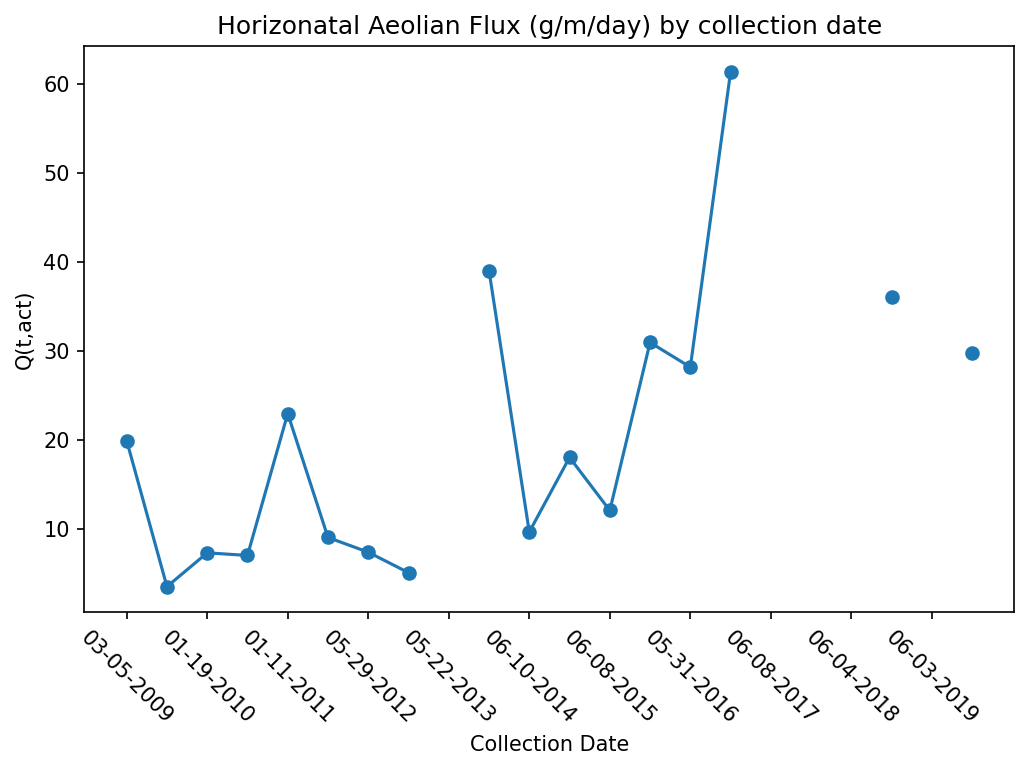

In [7]:
# Plot result
fig, ax = plt.subplots(figsize = (8,5))
tick_savers = np.arange(0, len(Q_by_date), 1)
ax.plot(tick_savers, Q_by_date["Q_field"].values, marker = 'o')

# Set xticks and labels 
ax.set_xticks(tick_savers[::2])
xtick_labels = [pd.to_datetime(x).strftime("%m-%d-%Y") for x in Q_by_date.index][::2]
ax.set_xticklabels(xtick_labels, rotation = -45)
ax.set_ylabel("Q(t,act)")
ax.set_xlabel("Collection Date")
plt.title("Horizonatal Aeolian Flux (g/m/day) by collection date")
plt.show()

# Save results 

In [8]:
save_path = "../data/site_data/NEAT"+neat_num+"/field_Q/NEAT"+neat_num+"_fieldQ.csv"
Q_by_date.to_csv(save_path, index=True)